In [1]:
import warnings
warnings.filterwarnings(action='ignore') 


In [2]:
!sudo apt-get install -y fonts-nanum                                        #패치 중....
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import urllib
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
from google.colab import drive
from scipy.stats import chisquare

mpl.rc("font", family='NanumBarunGothic')
mpl.rc('axes', unicode_minus=False)


In [50]:
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/'

df = pd.read_csv(url + 'vgames2.csv').drop('Unnamed: 0', axis=1 )

df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [51]:
def dropKM(dataFrame) :                                                          # K를 지워주고 대신 0.001을 곱해주는 함수 구현
  for i in range(len(dataFrame)) :                                              # 동시에 M 은 그냥 드롭
   if dataFrame.loc[i].find('K') != -1 :
       temp = dataFrame.loc[i]
       temp = temp.replace('K','')
       temp = float (temp)
       temp = temp *0.001
       dataFrame.loc[i] = temp
   elif dataFrame.loc[i].find('M') != -1 :
      temp = dataFrame.loc[i]
      temp = temp.replace('M','')
      dataFrame.loc[i] = temp



dropKM(df['NA_Sales'])
dropKM(df['EU_Sales'])
dropKM(df['JP_Sales'])
dropKM(df['Other_Sales'])                                                        # K 가 들어간 애들에서 K 제거 M 도 제거



In [52]:
df = df.drop(6906, axis=0)                                                      # 2020년의 자료가 있을리 없는데 잇어서 drop


In [53]:
df['NA_Sales'] = pd.to_numeric(df['NA_Sales'])
df['EU_Sales'] = pd.to_numeric(df['EU_Sales'])
df['JP_Sales'] = pd.to_numeric(df['JP_Sales'])
df['Other_Sales'] = pd.to_numeric(df['Other_Sales'])                            # 수치를 비교할 것이기때문에 데이터 타입을 변경.

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16597 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16597 non-null  object 
 1   Platform     16597 non-null  object 
 2   Year         16326 non-null  float64
 3   Genre        16547 non-null  object 
 4   Publisher    16539 non-null  object 
 5   NA_Sales     16597 non-null  float64
 6   EU_Sales     16597 non-null  float64
 7   JP_Sales     16597 non-null  float64
 8   Other_Sales  16597 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.3+ MB


In [55]:
df.isnull().sum()                                                               # 결측치는 전체 크기에 비해 미미 하므로 드롭.

df = df.dropna(axis=0)                                                          # nan 값이는 행 전체 제거
df = df.reset_index(drop = True)                                                # 약 300개의 데이터가 손실되었지만 전체 16500여개의 데이터에서는 큰 비율을 차지하지 않으므로 넘어간다!

df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04
...,...,...,...,...,...,...,...,...,...
16235,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01
16236,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00
16237,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16238,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [56]:
df['Global_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']         # 전체 판매량을 확인하가위해 Global Sales 항목 추가.
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16235,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16236,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16237,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16238,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


In [10]:
def year(x):
  if (x >= 0) & (x < 20):
    return int(2000 + x)
  elif (x > 30) & (x < 1000):
    return int(1900 + x)
  else:
    return int(x)

df['Year'] = df['Year'].apply(year)
df                                                                              # Year 표시가 4개로 되잇지 않은 것들이 잇어서 수정.


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16235,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16236,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16237,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16238,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


In [11]:
df.describe()


,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000
mean,2006.405911,0.265195,0.147387,0.078288,0.048236,0.539106
std,5.831291,0.822456,0.508354,0.309281,0.189684,1.563952
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,2017.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [12]:
n_Platform = df['Platform'].unique() 
n_Year = df['Year'].unique() 
n_Publisher = df['Publisher'].unique() 
n_Genre = df['Genre'].unique() 

print(len(n_Genre))
print(n_Genre)
print(len(n_Publisher))
print(n_Publisher)
print(len(n_Year))
print(n_Year)
print(len(n_Platform))
print(n_Platform)                                                 # 장르 연도 플랫폼 등에 대한 검증을 할 예정이라 그룹에 대한 확인을 해봄

12
['Action' 'Adventure' 'Misc' 'Platform' 'Sports' 'Simulation' 'Racing'
 'Role-Playing' 'Puzzle' 'Strategy' 'Fighting' 'Shooter']
575
['Destineer' 'Namco Bandai Games' 'Alchemist' 'Zoo Games' 'D3Publisher'
 'Konami Digital Entertainment' 'Deep Silver' 'Tecmo Koei' 'Sega' 'THQ'
 'Empire Interactive' 'Ubisoft' 'Paradox Interactive' '505 Games'
 'Tomy Corporation' 'Eidos Interactive' 'Microsoft Game Studios'
 'Nippon Ichi Software' 'Kalypso Media' 'Electronic Arts'
 'Sony Computer Entertainment' 'Activision' 'Tru Blu Entertainment'
 'Warner Bros. Interactive Entertainment' 'Midway Games' 'Mindscape'
 'Wargaming.net' 'Capcom' 'Acclaim Entertainment' 'Unknown' 'Nintendo'
 'Disney Interactive Studios' 'Crave Entertainment' 'Sunflowers'
 'Arc System Works' 'Milestone S.r.l' 'Kamui' 'Hudson Soft' 'Square Enix'
 'Focus Home Interactive' 'Take-Two Interactive' 'Game Factory'
 'Takara Tomy' 'SquareSoft' 'Global Star' 'Infogrames' 'GT Interactive'
 'Storm City Games' 'Gathering of Developers' 'G

In [13]:
df_G = df.groupby(by=['Genre'])['Global_Sales'].sum()
df_G = df_G.reset_index()
df_G_index = df_G['Genre']
df_G_NA = df.groupby(by=['Genre'])['NA_Sales'].sum()
df_G_NA = df_G_NA.reset_index()

df_G_EU = df.groupby(by=['Genre'])['EU_Sales'].sum()
df_G_EU = df_G_EU.reset_index()

df_G_JP = df.groupby(by=['Genre'])['JP_Sales'].sum()
df_G_JP = df_G_JP.reset_index()

df_G_OT = df.groupby(by= ['Genre'])['Other_Sales'].sum()
df_G_OT = df_G_OT.reset_index()

df_G = pd.concat([df_G, df_G_NA, df_G_EU, df_G_JP, df_G_OT], axis= 1)
df_G = df_G.set_index('Genre')
df_G = df_G.reset_index().drop('Genre', axis=1)
df_G = pd.concat([df_G_index, df_G],axis =1)
df_G = df_G.set_index('Genre')
df_G

,Global_Sales,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,,
Action,1712.98,858.75,513.64,156.60,183.99
Adventure,234.02,101.79,63.66,51.87,16.70
Fighting,443.54,220.35,99.90,87.14,36.15
Misc,779.70,394.73,208.15,104.18,72.64
Platform,827.99,445.38,200.63,130.53,51.45
Puzzle,240.73,121.58,50.47,56.24,12.44
Racing,722.55,354.70,235.02,56.32,76.51
Role-Playing,901.51,318.76,183.09,342.93,56.73
Shooter,1024.75,574.48,310.23,38.18,101.86


In [29]:
import scipy.stats
chi1, pvalue, dof, expected = scipy.stats.chi2_contingency(df_G)

print(chi1)
print(pvalue)
print(dof)
print(expected)                                                                 # 일본의 경우 기댓값과 꽤나 다르게 나온다

684.3522165592789
8.572793938468602e-116
44
[[1712.98        842.64345667  468.31525681  248.75451078  153.26677575]
 [ 234.02        115.11834448   63.97922708   33.98377717   20.93865127]
 [ 443.54        218.18472999  121.26034688   64.40972791   39.68519522]
 [ 779.7         383.54744548  213.16384648  113.22601084   69.7626972 ]
 [ 827.99        407.30210259  226.3659526   120.23855934   74.08338547]
 [ 240.73        118.41910549   65.81368829   34.95818596   21.53902026]
 [ 722.55        355.43440648  197.53948605  104.92683613   64.64927134]
 [ 901.51        443.46781785  246.46574225  130.91494297   80.66149693]
 [1024.75        504.09163109  280.15858879  148.81153599   91.68824414]
 [ 388.99        191.35067439  106.346806     56.48811845   34.80440116]
 [1305.34        642.11853596  356.86968752  189.55808772  116.79368881]
 [ 172.98         85.09174954   47.29137125   25.11970675   15.47717245]]


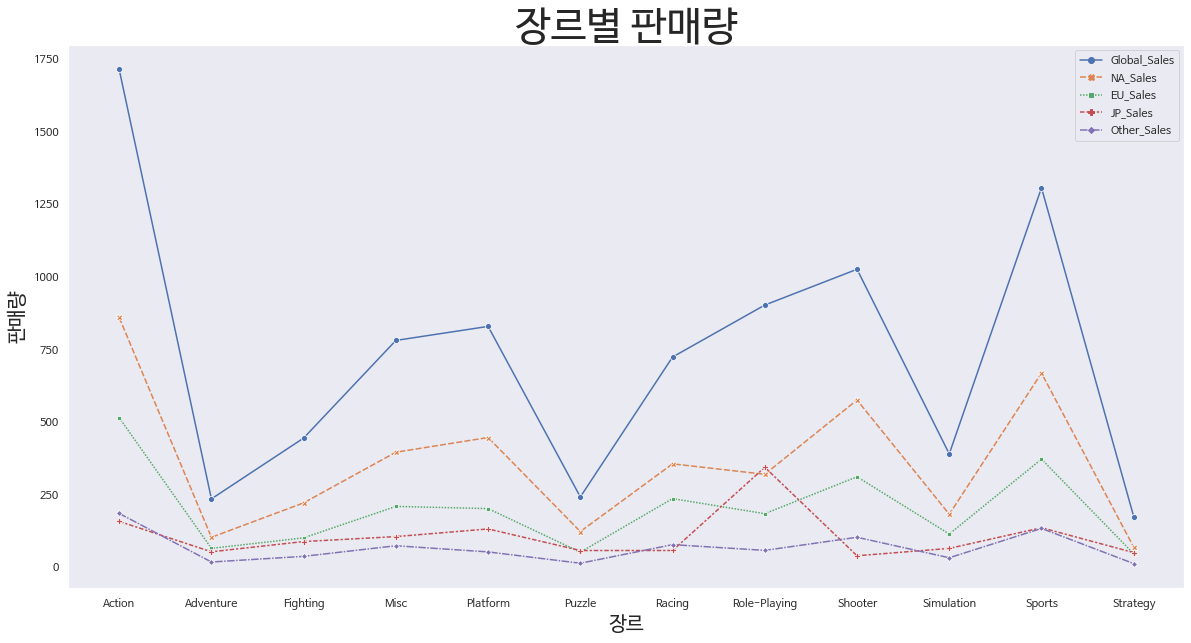

In [63]:
sns.set(style = 'dark', font = 'NanumBarunGothic')
plt.figure(figsize = (20,10))
sns.lineplot(data=df_G, markers=True);
plt.title("장르별 판매량", fontsize = 40)
plt.xlabel('장르', fontsize = 20)
plt.ylabel('판매량', fontsize = 20)

plt.show()                                                                      # 장르별 지역별 선호도를 그래프로 만들어 보았다. 일본을 제외한 지역에서는 Action 이 압도적. 그리고 2위로는 스포츠 슈팅등.
                                                                                # 일본은 롤플레잉이 1위

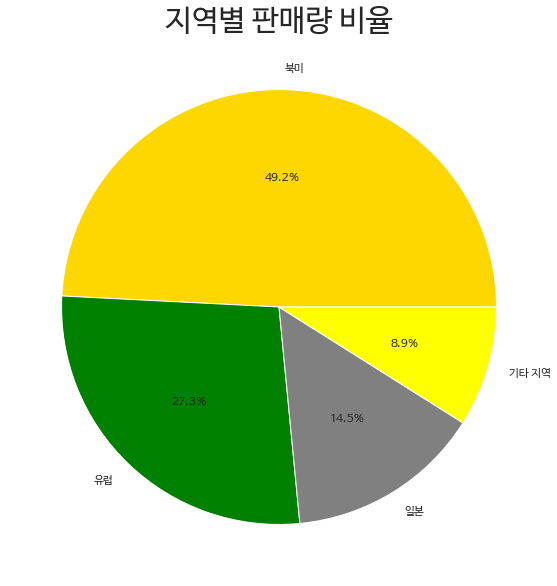

In [65]:
#시장규모

ratio = [df['NA_Sales'].sum()/df['Global_Sales'].sum(), df['EU_Sales'].sum()/df['Global_Sales'].sum(), df['JP_Sales'].sum()/df['Global_Sales'].sum(), df['Other_Sales'].sum()/df['Global_Sales'].sum()]
labels = ['북미', '유럽', '일본', '기타 지역']
colors = ['gold','green', 'gray', 'yellow']

plt.figure(figsize=(20,10))
plt.pie(ratio, labels=labels, autopct='%.1f%%', colors = colors)
plt.title("지역별 판매량 비율", fontsize = 30)
plt.show()

In [16]:
df_Y_e1 = df.groupby(by=['Year', 'Genre'])['Global_Sales'].sum().reset_index()

df_Y_e2 = df_Y_e1.groupby(by=['Year'])['Global_Sales'].transform(max) == df_Y_e1['Global_Sales']
df_Y_G = df_Y_e1[df_Y_e2].reset_index(drop=True)
df_Y_G

,Year,Genre,Global_Sales
0,1980,Shooter,7.07
1,1981,Action,14.79
2,1982,Puzzle,10.04
3,1983,Platform,6.93
4,1984,Shooter,31.10
5,1985,Platform,43.17
6,1986,Action,13.74
7,1987,Fighting,5.42
8,1988,Platform,27.73
9,1989,Puzzle,37.75


In [17]:
df_Y_e1 = df.groupby(by=['Year', 'Genre'])['NA_Sales'].sum().reset_index()

df_Y_e2 = df_Y_e1.groupby(by=['Year'])['NA_Sales'].transform(max) == df_Y_e1['NA_Sales']
df_Y_NA = df_Y_e1[df_Y_e2].reset_index(drop=True)
df_Y_NA = df_Y_NA.drop(38, axis=0) 

In [18]:
df_Y_e1 = df.groupby(by=['Year', 'Genre'])['EU_Sales'].sum().reset_index()
df_Y_e2 = df_Y_e1.groupby(by=['Year'])['EU_Sales'].transform(max) == df_Y_e1['EU_Sales']
df_Y_EU = df_Y_e1[df_Y_e2].reset_index(drop=True)
df_Y_EU = df_Y_EU.drop(38, axis=0)                                              # 값이 0 이여서 중복되는 max 값을 나타내는 부분은 드롭해줬다.


df_Y_e1 = df.groupby(by=['Year', 'Genre'])['JP_Sales'].sum().reset_index()
df_Y_e2 = df_Y_e1.groupby(by=['Year'])['JP_Sales'].transform(max) == df_Y_e1['JP_Sales']
df_Y_JP = df_Y_e1[df_Y_e2].reset_index(drop=True)
df_Y_JP = df_Y_JP.drop([1,2,3,5,6,7,8,9,10,12,13,14,15,16,17], axis=0).reset_index(drop=True)

df_Y_e1 = df.groupby(by=['Year', 'Genre'])['Other_Sales'].sum().reset_index()
df_Y_e2 = df_Y_e1.groupby(by=['Year'])['Other_Sales'].transform(max) == df_Y_e1['Other_Sales']
df_Y_OT = df_Y_e1[df_Y_e2].reset_index(drop=True)                               # 지역별 해당 년도 제일 잘 팔린 장르에 대해서.
df_Y_OT = df_Y_OT.drop(38, axis=0)     



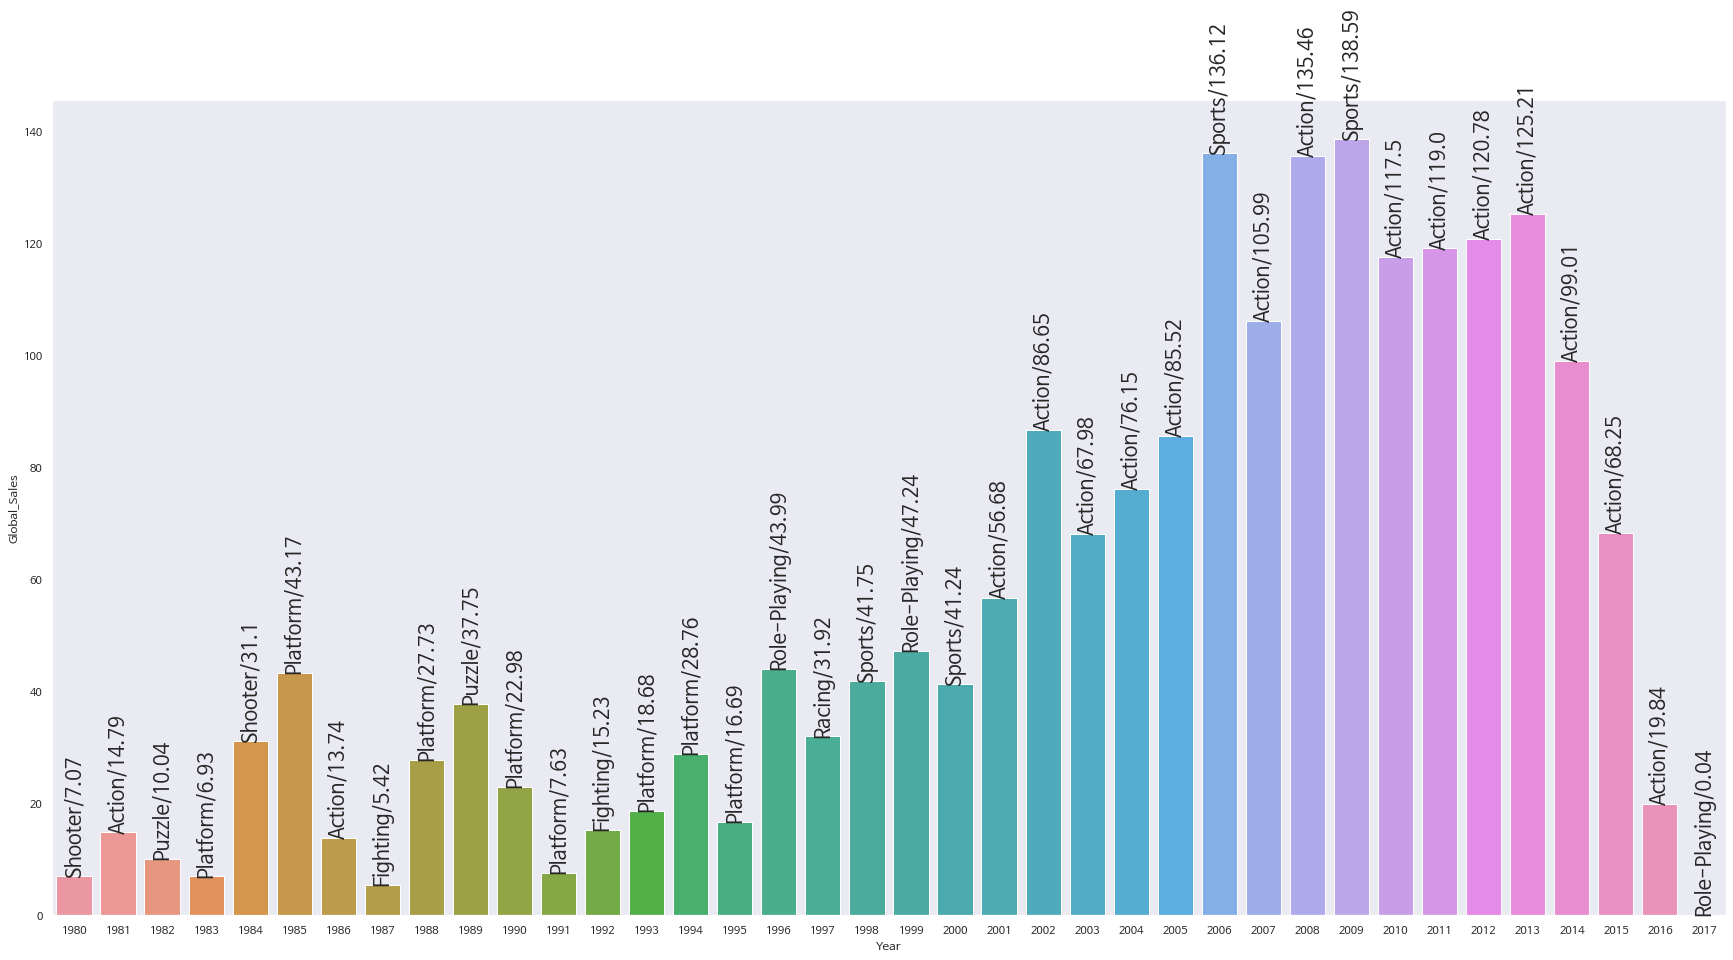

In [19]:
genre_G = df_Y_G['Genre']

plt.figure(figsize = (30,15))
g = sns.barplot(x = 'Year', y='Global_Sales', data = df_Y_G)
index= 0
for value in df_Y_G['Global_Sales']:
  g.text(index, value+1, str(genre_G[index]+ '/' + str(round(value,2))),size = 20, rotation = 90,ha = 'center')
  index += 1

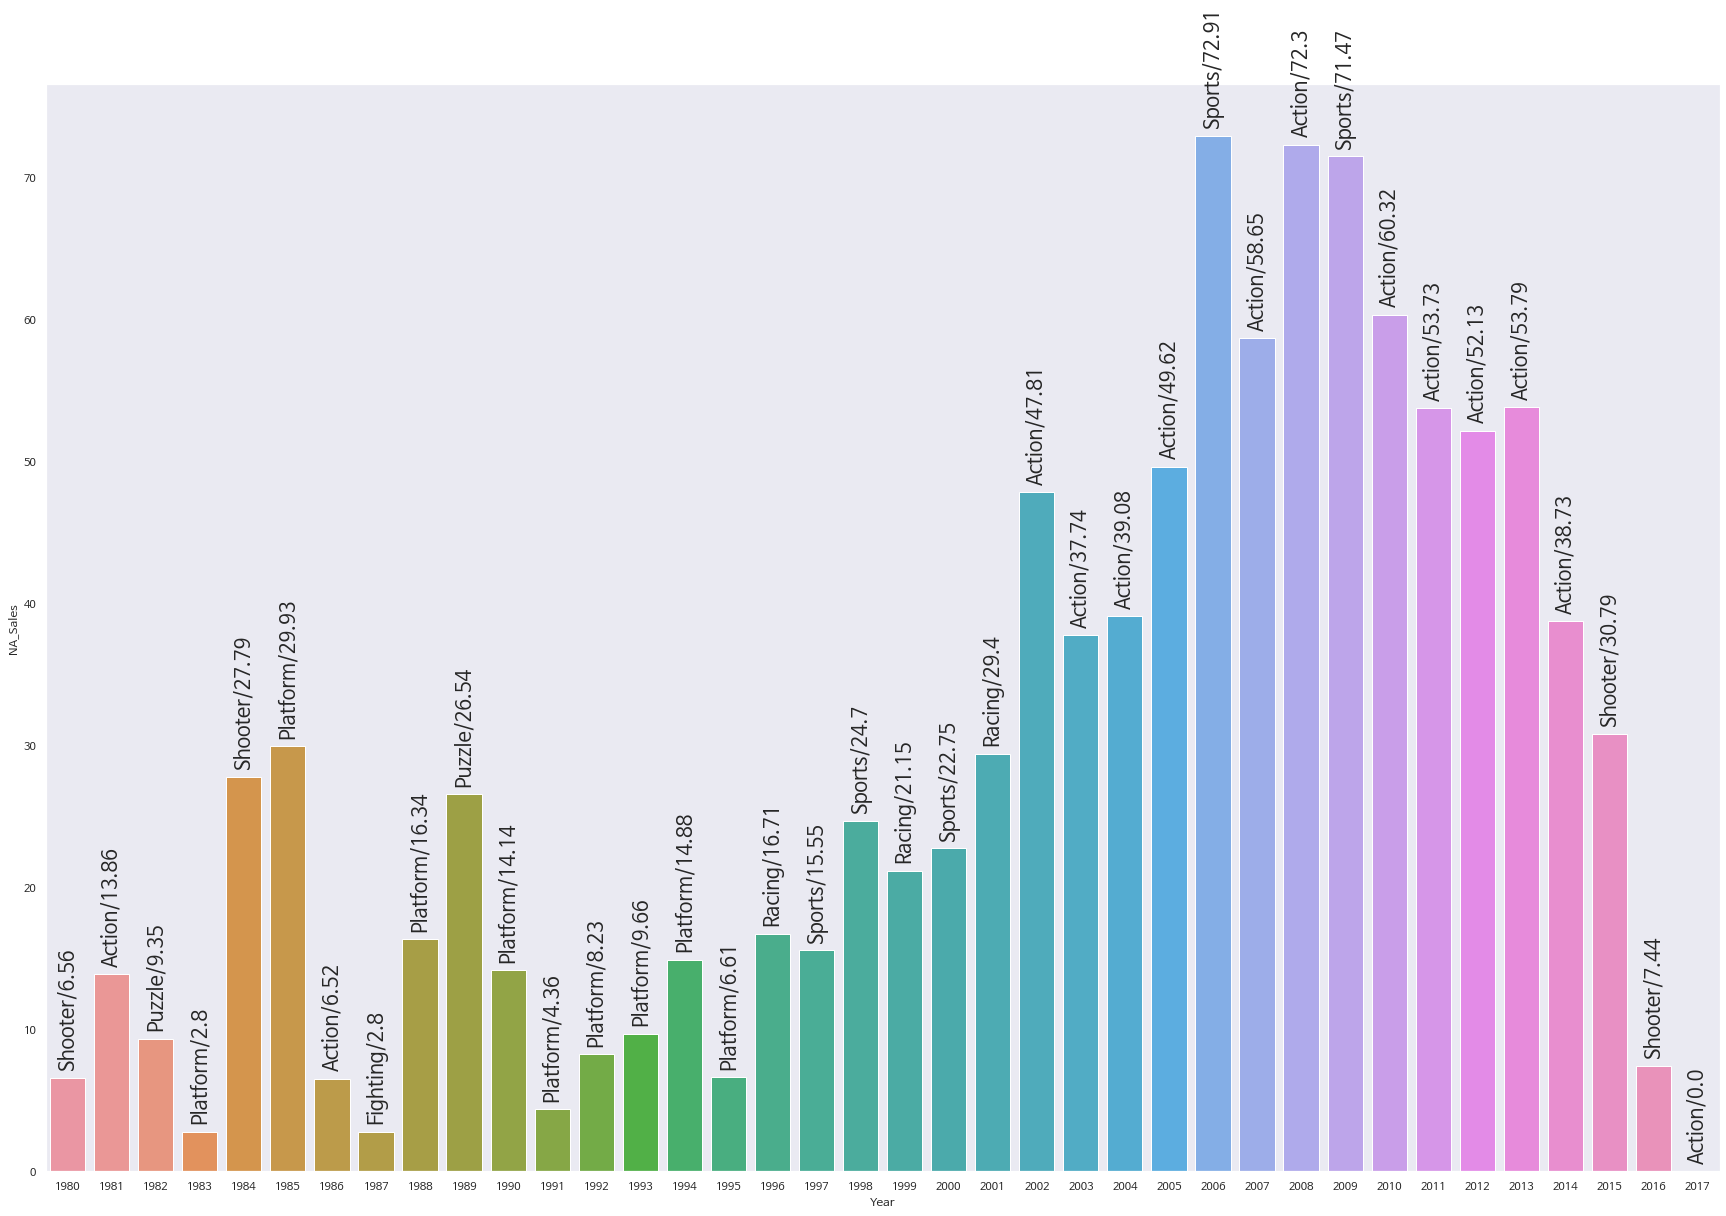

In [20]:
genre_NA = df_Y_NA['Genre']

plt.figure(figsize = (30,20))
g = sns.barplot(x = 'Year', y='NA_Sales', data = df_Y_NA)
index= 0
for value in df_Y_NA['NA_Sales']:
  g.text(index, value+1, str(genre_NA[index]+ '/' + str(round(value,2))),size = 20, rotation = 90,ha = 'center')
  index += 1

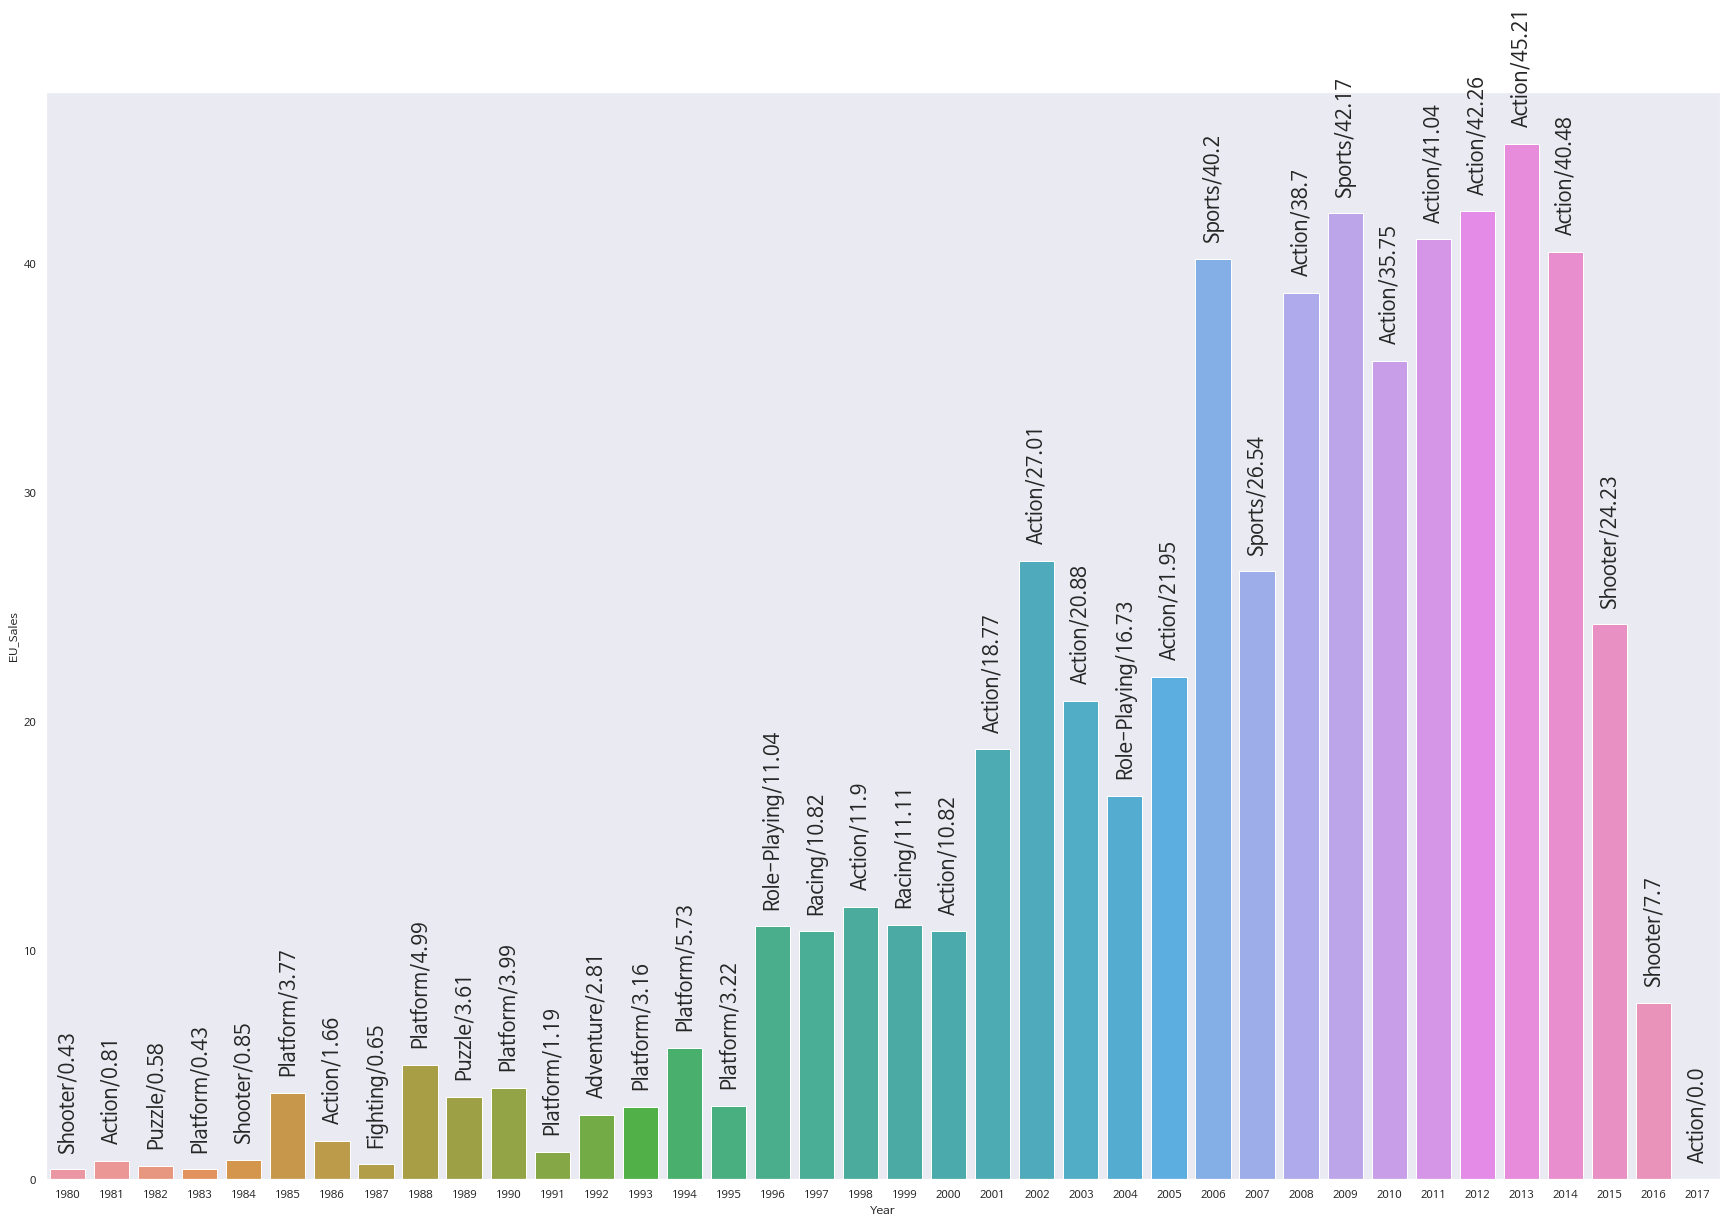

In [21]:
genre_EU = df_Y_EU['Genre']

plt.figure(figsize = (30,20))
g = sns.barplot(x = 'Year', y='EU_Sales', data = df_Y_EU)
index= 0
for value in df_Y_EU['EU_Sales']:
  g.text(index, value+1, str(genre_EU[index]+ '/' + str(round(value,2))),size = 20, rotation = 90,ha = 'center')
  index += 1

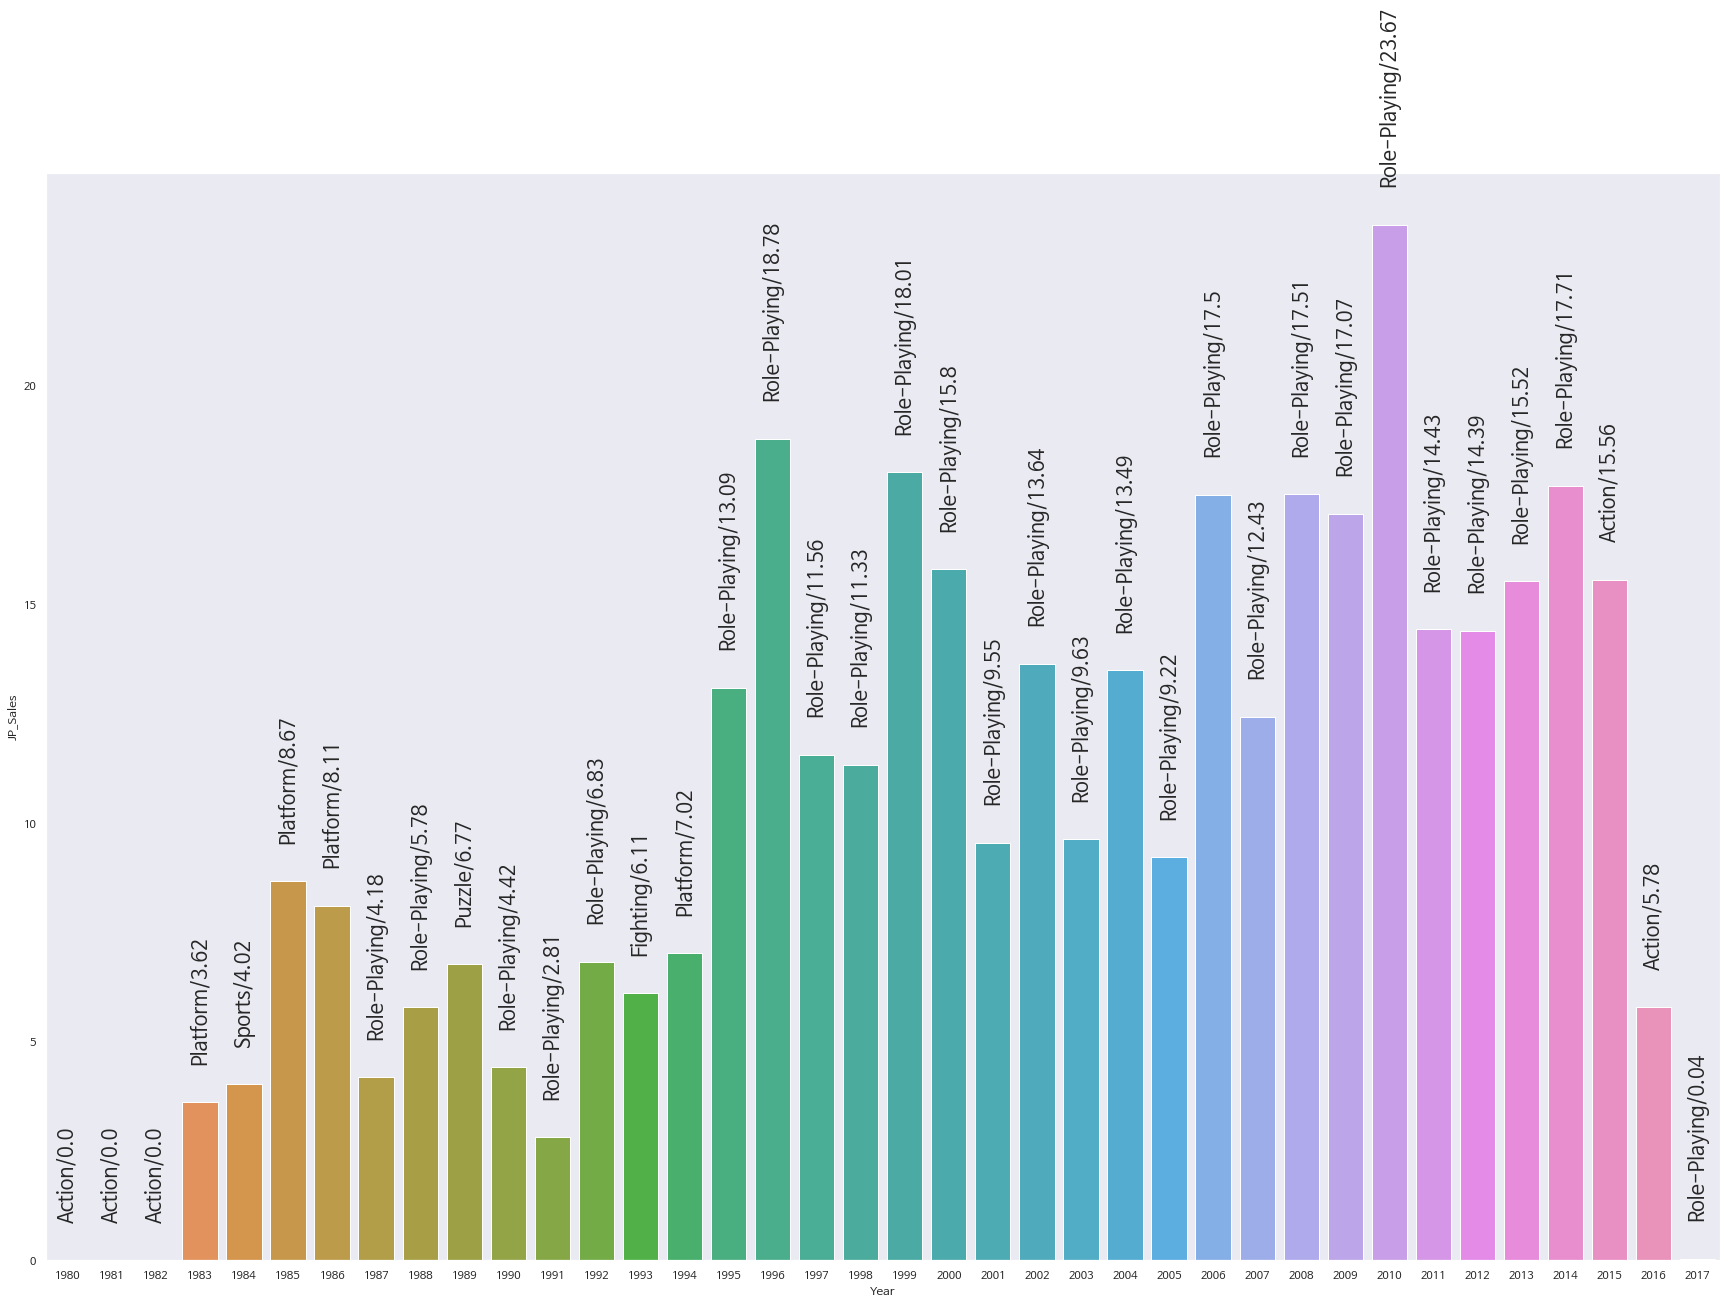

In [22]:
genre_JP = df_Y_JP['Genre']

plt.figure(figsize = (30,20))
g = sns.barplot(x = 'Year', y='JP_Sales', data = df_Y_JP)
index= 0
for value in df_Y_JP['JP_Sales']:
  g.text(index, value+1, str(genre_JP[index]+ '/' + str(round(value,2))),size = 20, rotation = 90,ha = 'center')
  index += 1



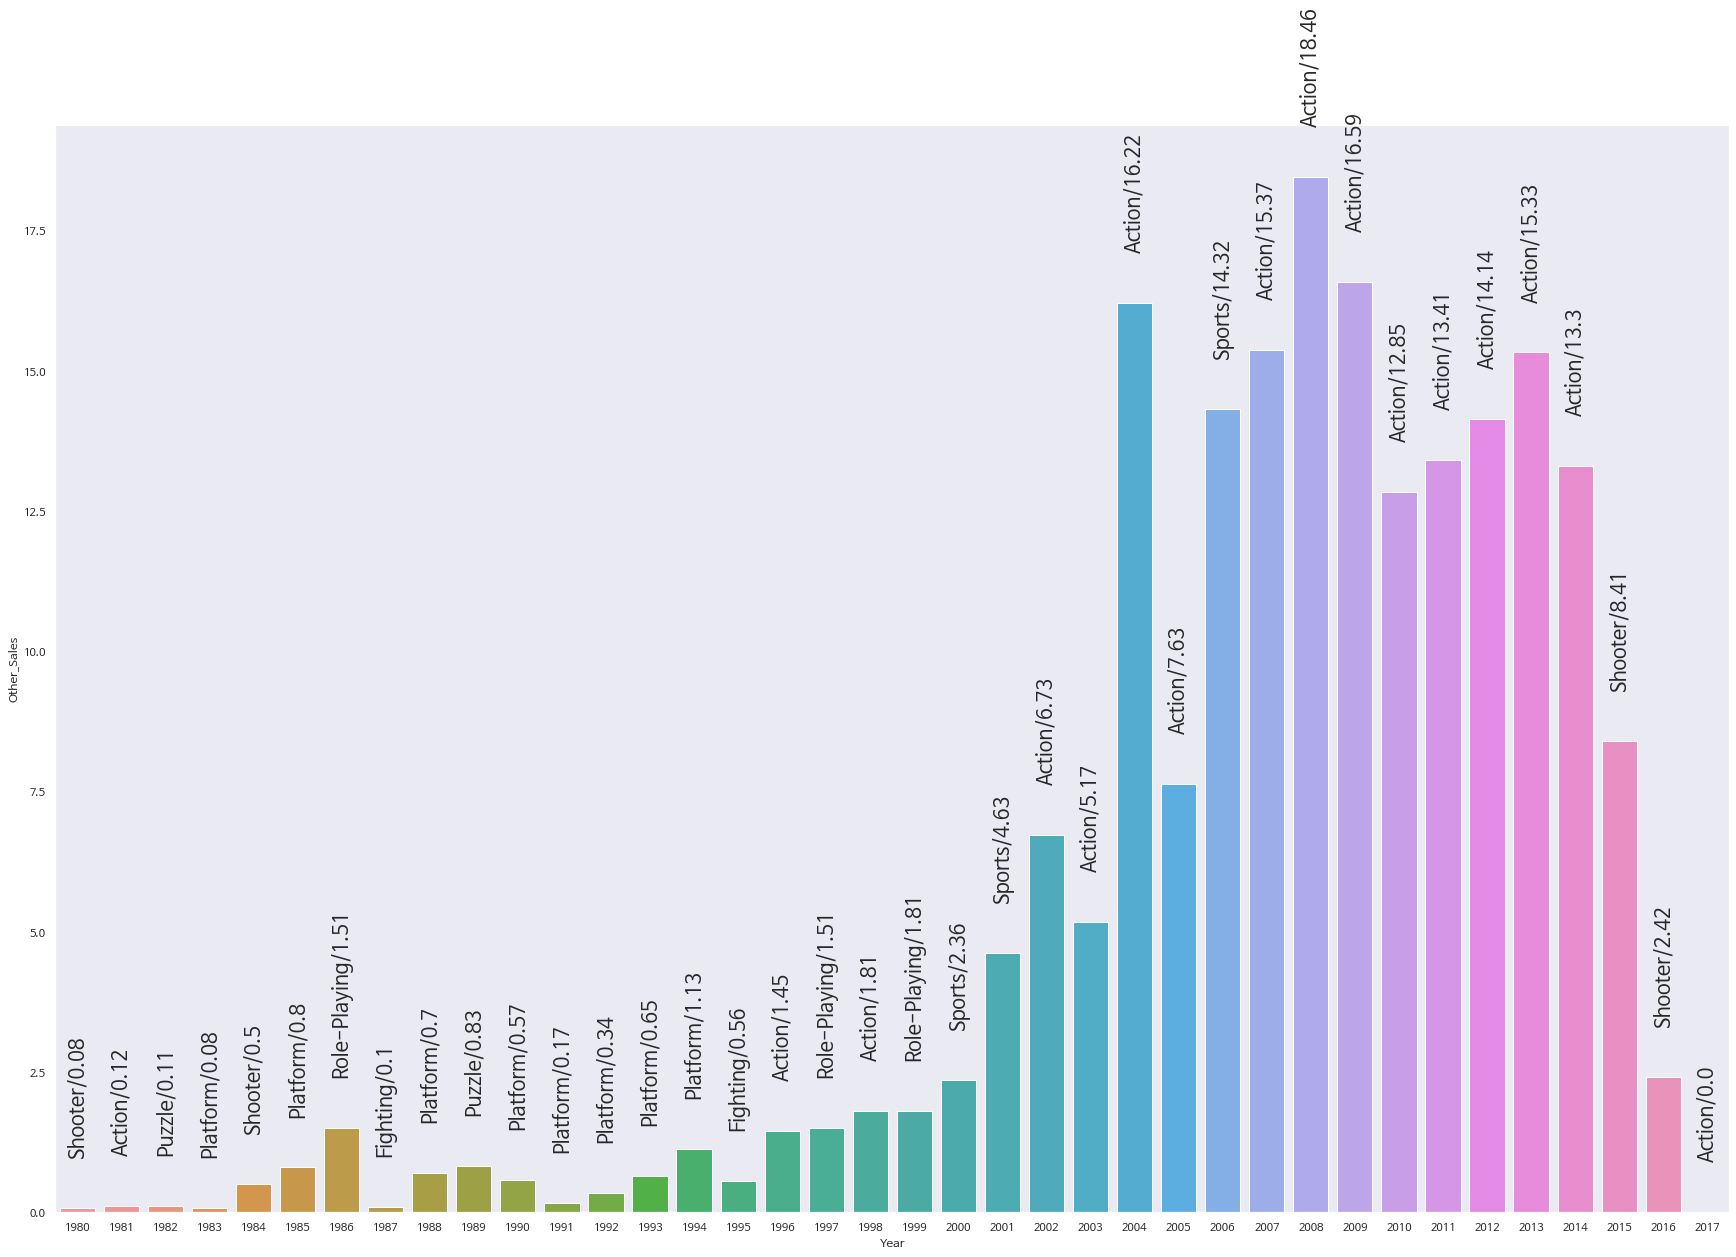

In [23]:
genre_OT = df_Y_OT['Genre']

plt.figure(figsize = (30,20))
g = sns.barplot(x = 'Year', y='Other_Sales', data = df_Y_OT)
index= 0
for value in df_Y_OT['Other_Sales']:
  g.text(index, value+1, str(genre_OT[index]+ '/' + str(round(value,2))),size = 20, rotation = 90,ha = 'center')
  index += 1

미국 유럽 일본 기타지역들의 자료와 글로벌 자료를 보았을때,
일본은 다른 지역과는 다른 양상의 판매량을 보인다.
즉 세계시장을 생각했을때, 일본 시장은 지역 특수성을 고려하여 배제하는게 좋을것으로 보인다.



In [36]:
# Platform 별 판매량 순위
df_P = df.groupby(by=['Platform'])['Global_Sales'].sum()
df_P = df_P.reset_index()
df_P_index = df_P['Platform']
df_P_NA = df.groupby(by=['Platform'])['NA_Sales'].sum()
df_P_NA = df_P_NA.reset_index()

df_P_EU = df.groupby(by=['Platform'])['EU_Sales'].sum()
df_P_EU = df_P_EU.reset_index()

df_P_JP = df.groupby(by=['Platform'])['JP_Sales'].sum()
df_P_JP = df_P_JP.reset_index()

df_P_OT = df.groupby(by= ['Platform'])['Other_Sales'].sum()
df_P_OT = df_P_OT.reset_index()

df_P = pd.concat([df_P, df_P_NA, df_P_EU, df_P_JP, df_P_OT], axis= 1)
df_P = df_P.set_index('Platform')
df_P = df_P.reset_index().drop('Platform', axis=1)
df_P = pd.concat([df_P_index, df_P],axis =1)
df_P = df_P.set_index('Platform')
df_P = df_P.sort_values(by=['Global_Sales'], ascending= False)
df_P = df_P.reset_index()
df_P

,Platform,Global_Sales,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,PS2,1222.44,568.54,332.03,134.10,187.77
1,X360,968.59,593.78,277.90,12.29,84.62
2,PS3,946.74,388.00,339.71,78.56,140.47
3,Wii,900.15,495.10,260.78,65.79,78.48
4,DS,816.90,387.66,194.05,174.97,60.22
5,PS,725.16,333.79,211.75,139.09,40.53
6,GBA,304.76,178.26,72.43,46.56,7.51
7,PSP,290.84,106.50,67.15,75.72,41.47
8,PS4,275.78,95.80,122.94,14.04,43.00
9,GB,254.43,113.64,47.51,85.12,8.16


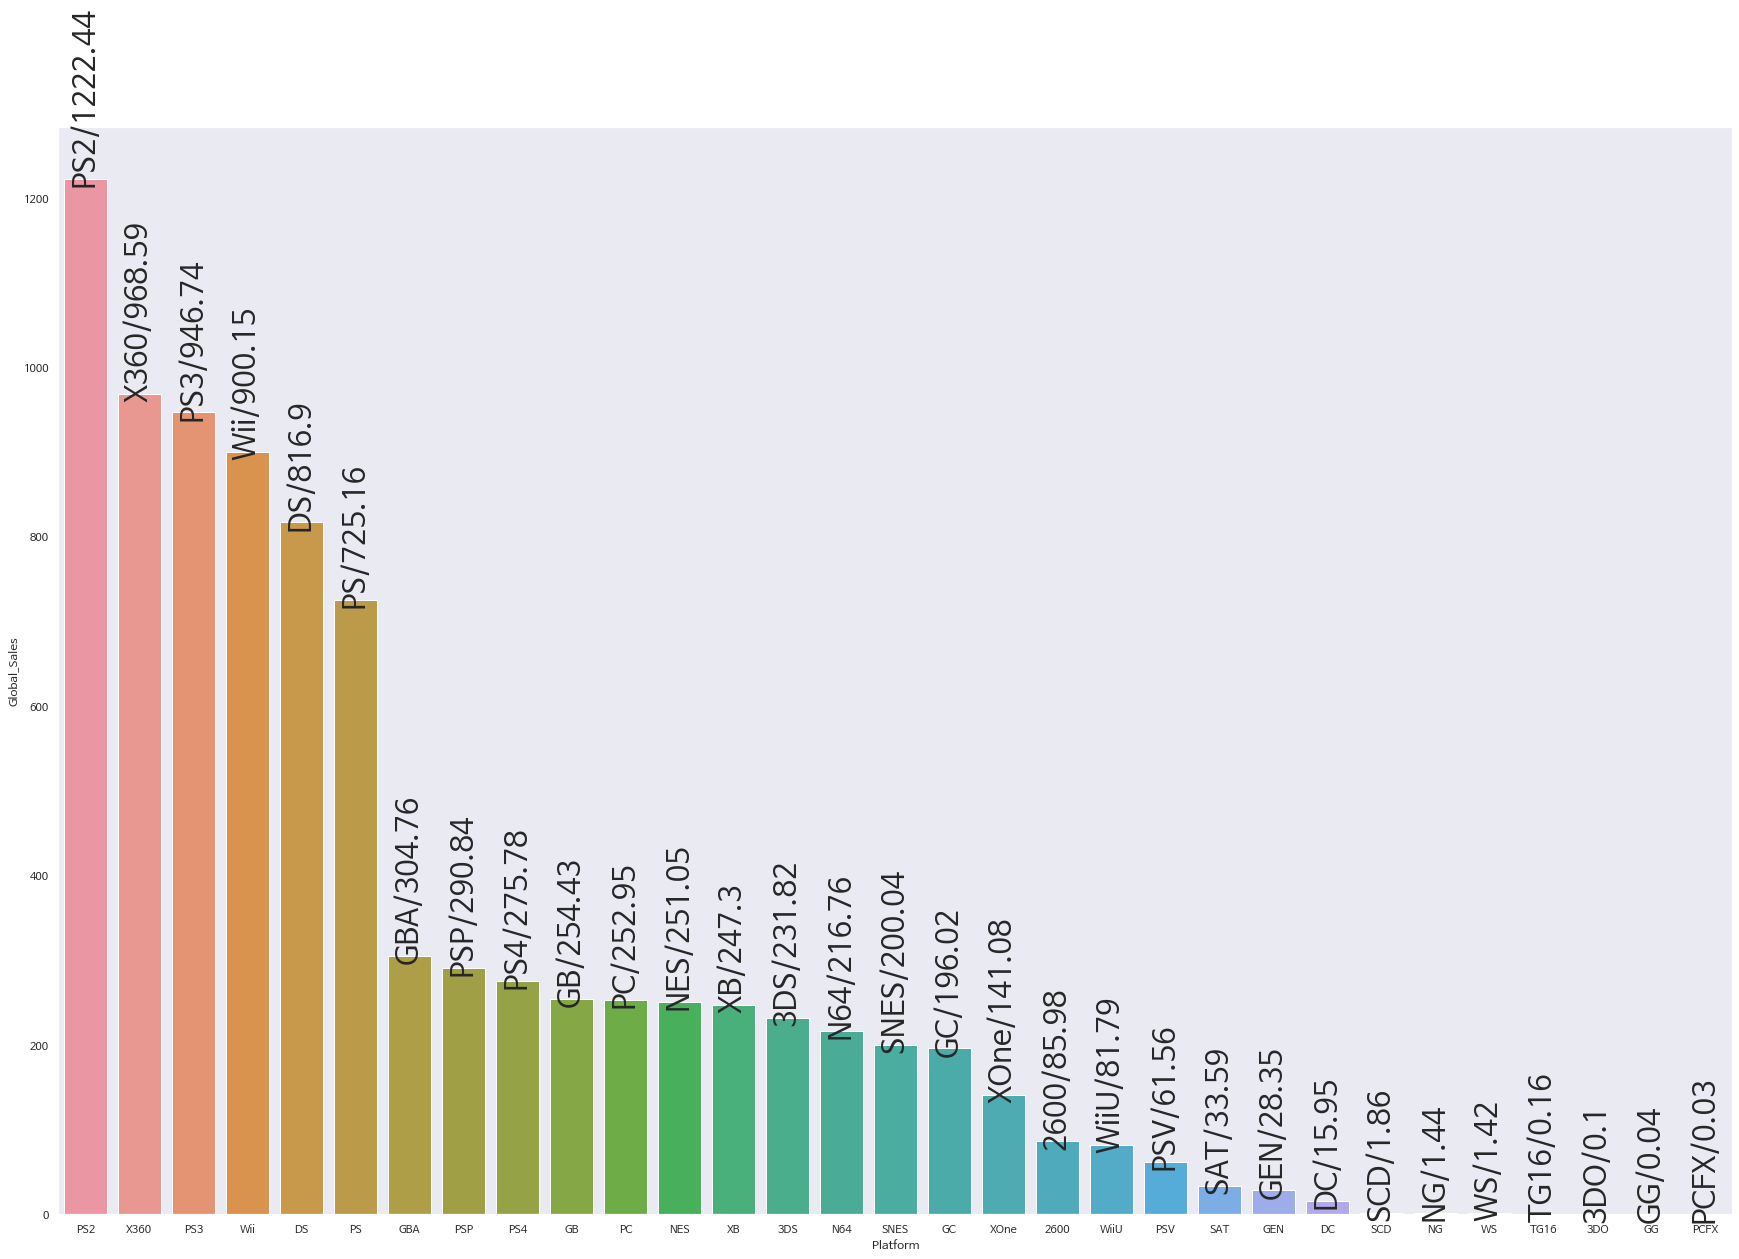

In [42]:
Platform_Gl = df_P['Platform']

plt.figure(figsize = (30,20))
g = sns.barplot(x = 'Platform', y='Global_Sales', data = df_P)
index= 0
for value in df_P['Global_Sales']:
  g.text(index, value+1, str(Platform_Gl[index]+ '/' + str(round(value,2))),size = 30, rotation = 90,ha = 'center')
  index += 1

In [57]:
#인기 게임 (개별)


n_df= df.sort_values(by=['Global_Sales'], ascending = False)

rank_df = n_df.head(30)
rank_df = rank_df.reset_index(drop=True)
rank_df



,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.61
9,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


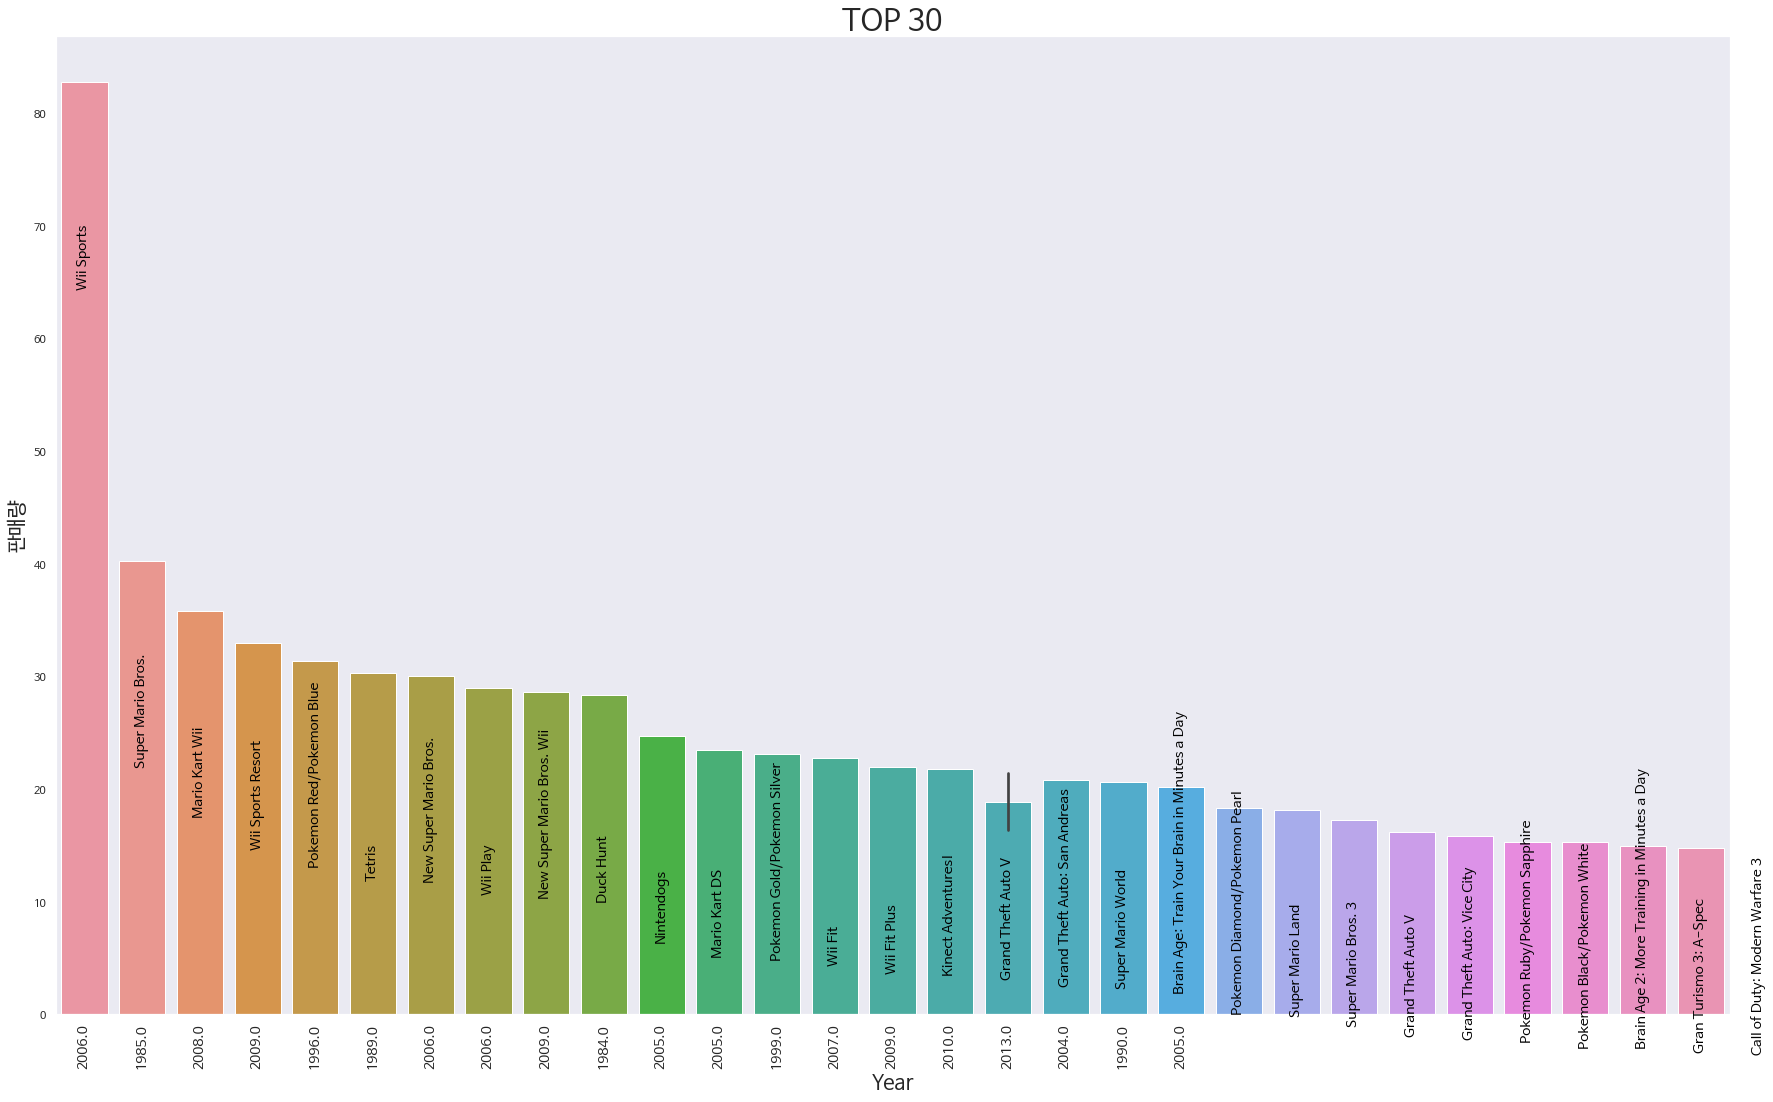

In [62]:
name = rank_df['Name']
year = rank_df['Year']
y = np.arange(0, 20)

plt.figure(figsize=(30, 18))
g = sns.barplot(x='Name', y='Global_Sales', data=rank_df)
index = 0
for value in rank_df['Global_Sales']:
    g.text(index, value - 18, name[index], color='#000', size=14, rotation= 90, ha="center")
    index += 1

plt.xticks(y, rank_df['Year'], fontsize=14, rotation=90)
plt.title("TOP 30", fontsize=30)
plt.xlabel("Year", fontsize=20)
plt.ylabel("판매량", fontsize=20)
plt.show()

In [58]:
rank_df_Wii = n_df['Platform'] == 'Wii'
rank_Wii=n_df[rank_df_Wii].head(30)
r_Wii = rank_Wii.groupby(by=['Genre'])['Global_Sales'].sum()

r_Wii = r_Wii.reset_index()
r_Wii

,Genre,Global_Sales
0,Action,17.25
1,Fighting,13.04
2,Misc,88.37
3,Platform,54.42
4,Racing,35.83
5,Shooter,4.99
6,Simulation,4.68
7,Sports,187.60


In [59]:
rank_df_X = n_df['Platform'] =='X360'
rank_X = n_df[rank_df_X].head(30)
r_X = rank_X.groupby(by=['Genre'])['Global_Sales'].sum()
r_X = r_X.reset_index()
r_X

,Genre,Global_Sales
0,Action,54.22
1,Adventure,5.55
2,Misc,31.02
3,Racing,5.52
4,Role-Playing,18.92
5,Shooter,148.15
6,Sports,6.24


In [60]:

rank_df_PS = n_df['Platform'] =='PS4'
rank_PS =n_df[rank_df_PS].head(30)
r_PS = rank_PS.groupby(by=['Genre'])['Global_Sales'].sum()
r_PS = r_PS.reset_index()
r_PS

,Genre,Global_Sales
0,Action,48.03
1,Fighting,2.70
2,Misc,4.02
3,Role-Playing,10.69
4,Shooter,54.08
5,Sports,29.84


In [61]:

rank_df_DS = n_df['Platform'] =='DS'
rank_DS = n_df[rank_df_DS].head(30)
r_DS = rank_DS.groupby(by=['Genre'])['Global_Sales'].sum()
r_DS = r_DS.reset_index()
r_DS

,Genre,Global_Sales
0,Action,21.96
1,Misc,50.40
2,Platform,40.43
3,Puzzle,24.54
4,Racing,23.43
5,Role-Playing,64.48
6,Simulation,50.04
7,Sports,8.67


In [41]:
df2 = pd.DataFrame({'Game' : ['Wii', 'Super mario', 'GTA', 'Brain Age', 'CoD', 'Pokemon', 'Tetris', 'Other'],
                    'Global_Sales' :[211.47 , 214.16, 74.73, 35.52, 14.76, 85.63, 30.26, 69.88]})
                   
df2


,Game,Global_Sales
0,Wii,211.47
1,Super mario,214.16
2,GTA,74.73
3,Brain Age,35.52
4,CoD,14.76
5,Pokemon,85.63
6,Tetris,30.26
7,Other,69.88


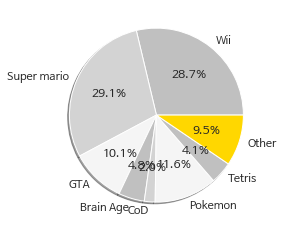

In [42]:

ratio = [211.47/df2['Global_Sales'].sum(), 214.16/df2['Global_Sales'].sum(), 74.73/df2['Global_Sales'].sum(), 35.52/df2['Global_Sales'].sum(), 14.76/df2['Global_Sales'].sum(), 85.63/df2['Global_Sales'].sum(), 30.26/df2['Global_Sales'].sum(), 69.88/df2['Global_Sales'].sum()]
labels = df2['Game']
colors = ['silver', 'lightgray', 'whitesmoke', 'silver','lightgray', 'whitesmoke', 'silver','gold' ]

plt.pie(ratio, labels= labels, autopct = '%.1f%%', shadow = True, colors = colors)

plt.show()


In [48]:


r_G = rank_df.groupby(by=['Genre'])['Global_Sales'].sum()
r_G = r_G.reset_index()
r_G = r_G.sort_values(by=['Global_Sales'], ascending = False).reset_index(drop=True)

r_G

,Genre,Global_Sales
0,Platform,178.32
1,Sports,160.46
2,Shooter,151.59
3,Role-Playing,129.95
4,Action,111.72
5,Racing,98.09
6,Misc,71.05
7,Puzzle,45.56
8,Simulation,37.03
9,Fighting,13.04
